# <span style="color:green">Early Detection of Crop Stress From Thermal Infrared Imagery</span>
Erik Anderson &
Tyler Cruickshank

[Project Repository](https://github.com/eriktuck/ea-lst-capstone)

![Hydrosat](https://uploads-ssl.webflow.com/61e4aee27ac4a95d23ab9609/61e9d6f5d6578e8c7c0cca8f_solutions-thermal-min.jpg)

# <span style="color:green">Project Overview</span>

<font size="4">Maximizing agricultural productivity is critical for maintaining world food supply and containing food cost.


Modern agribusiness employs targeted technology to <span style="color:lightblue">optimize cropland productivity</span> using modern information and communication technologies at fine spatial resolution (within-field scale). High resolution remotely sensed data of soil conditions and vegetation health provides near real-time information that informs <span style="color:lightblue">adaptive irrigation and fertilization technology</span>. The Normalized Difference Vegetation Index (NDVI) is a commonly used remotely sensed index that provides data on the "greenness" or health of crop vegetation. However, the NDVI index is a lagging indicator of crop stress because water or heat stress occurs prior to the degradation of vegetation greenness.

This project aims to support this effort by exploring the relationship between land surface temperature and canopy temperature, an index known as Canopy Air Temperature Index (CATD), to evaluate the availability of moisture to the crops. When crop moisture is limited, leaf stomata close which prevents cooling of the leaf surface and leads to a larger values of CATD.</font>

## <span style="color:green">Project Location</span>

<font size="4">The project is focused on agricultural areas with active farming.  At present, we are extracting data for locations in the San Joaquin Valley, CA and near Ames, Iowa.  In this notebook, we are focused on developing a process for extracting and evaluating time-series data from a point location.  Future notebook iterations may include a spatial analysis that incorporates processes developed from our time-series work.</font>

# <span style="color:green">Data Overview</span></span>

<font size="4">Hydrosat provides a proprietary "fused" thermal infrared land surface temperature (LST) imagery product that is downscaled to 20 m resolution using a combination of MODIS, Sentinel and Landsat imaging platforms.  Hydrosat utilizes a data mining approach for sharpening thermal satellite imagery (DMS) (Gao, F. 2012) and a separate algorithm for interpolating land surface temperature between measurement points (STARFM) (Gao, F 2006). This high resolution fused product is produced daily and presents an added value opportunity for agribusiness.  The same process produces a paired downscaled 20m NDVI fused product.

The data is accessed from a Spatial Temporal Asset Catalog (STAC).  STAC is a specification standard with a unified language to describe geospatial data which allows it to be more easily searchable and queryable. </font>

# <span style="color:green">Notebook Code Overview</span>

<font size="4">At present, this notebook is designed to perform an analysis for a time-series of single specified point.

The backbone of this notebook utilizes the Hydrosat Fusion Hub class.  The class has methods for:
1. Logging in to the STAC.
2. Querying the STAC for specified imagery.
3. Creating a FH Hydrosat object which provides purposeful utility.
4. Extracting time-series for a point location.

We have written additional code to:
1. Extract time-series of individual components of the fused LST data products.
2. Plot the individual components to reveal variations in each component.
3. Extract meteorological data for the time-frame using the HRRR API.
4. Compute a Canopy Air Temperature Difference (CATD) time-series product using LST and air temperature
5. Extract and compute time-series of NDVI components of the fused NDVI data product.
5. Plot the individual NDVI components.
</font>

## <span style="color:green">References</span>

Gao, F. Masek, J. Schwaller, M. Hall, F. 2006. On the Blending of Landsat and MODIS Surface Reflectance: Predicting Landsat Surface Reflectance. IEE Transaction on Geoscience and Remote Sensing Vol 44, No 8.

Gao, F. Kustas, W. Anderson, M. 2012. A Data Mining Approach for Sharpening Thermal Satellite Imagery Over Land. Remote Sensing. doi: 10.3390/rs4113287.

Karnieli, A., Agam, N., Pinker, R., Anderseon, M., Imhoff, M., Gutman, G., Panov, N., Goldberg, A., Use of NDVI and Land Surface Temperature for Drought Assessment: Merits and Limitations.  Journal of Climate. Vol 23. 2010

Y. Erdem , T. Erdem , A.H. Orta & H. Okursoy. Canopy-air temperature differential for potato under different irrigation regimes. Acta Agriculturae Scandinavica Section B-Soil and Plant Science, 2006; 56: 206216


## <span style="color:green">Collaborators </span>

- [Erik Anderson](https://github.com/eriktuck)
- [Tyler Cruickshank](https://github.com/tcruicks)
- [Joe McGlinchy](https://github.com/joemcglinchy)
We thank Joe McGlinchy of Hydrosat for providing project guidance and data access.

In [1]:
import base64
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import os
import pystac
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio

#from botocore.exceptions import ClientError
from datetime import date
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from distutils.command import sdist
from matplotlib import pyplot as plt
from pyproj.crs import CRS
from pystac_client import Client
from pprint import pprint
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.linear_model import LinearRegression

# Project specific packages
from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat
from herbie import FastHerbie
#import synoptic.services as ss
#from synoptic.services import stations_timeseries

os.environ['USE_PYGEOS'] = '0'


/var/folders/zs/pstrmbpn6t75t6hdl9_v8_8w0000gn/T/ipykernel_68160/979758809.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


## Functions
This section defines a number of functions for later use. No user editing is required.

In [2]:
# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.

    Parameters:
    ----------
    collection: list
        List of tiles found in STAC.

    geom: 
        Point location to search.

    start_date, end_date: str
        Dates to search between.

    Returns:
    -------
    """

    search = catalog.search(
        collections = collection,
        intersects = geom,
        datetime = [start_date, end_date],
        max_items = 1000,
    )

    #items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items()) # for pystac-client < 0.4.0

    # Filter out only the newest version of MODIS.
    if collection == 'prepped_inputs_mcd43a4':
        version_str = '061'
        new_list = [i for i in found_items if version_str in i.id]
        found_items = new_list

    found_items.reverse() # make the results ascending in time

    num_tiles = len(found_items)
    print ("    Colllection: {} \n".format(collection))
    print ("    Number of fusion tiles available: {}".format(num_tiles))
    print ("\n")

    return (found_items, num_tiles)

# ---------------------------------------------------------------------------------

def create_clip_polygon(geom, ds, buffer):
    """
    Create a polygon that we will use for clipping the big dataset.

    Parameters:
    ----------
    geom: dict
        Dictionary of lat and lon of center point of AOI.

    Returns:
    -------
    poly: dataframe
        Contains geometry of a square to be used for clipping.
    """
    # Using the point coords defined earlier, create a df with the point geometry.
    p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
    point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

    # Define a buffer size (for each side of the point.
    # Reproject the point df and create the new polygon.
    raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
    buffer_dist = buffer # 1km in local UTM zone

    # create a square buffer
    poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) 

    return(poly_df)

# ---------------------------------------------------------------------------------

def create_aoi_image_stack(items, num_tiles, geom, buffer):
    '''
    Gets images, stacks them and sorts them by date and clips them down to a smaller
    AOI size.

    Parameters:
    -----------
    itmes: list 
        List of available images.
    num_tiles: int
        Number of tiles to download (days)
    asset: str
        Name of asset to get.
    geom: x,y coords
        Coordinates around which to build a polygon
    buffer: int
        Buffer around the x,y for creating the AOI rectangele.  In meters.

    Returns:
    --------
    aoi_stack_ds: dataset as FH_StackedDataset object.
        Stack of images clipped to AOI.

    '''
    images = FH_Hydrosat(items[:num_tiles])  #, asset=asset)

    # Stacks all the files into a dataset and then return a FH_StackedDataset object.
    stacked_images = images.stack()
    # Sort the dataset by time.
    ds = stacked_images.ds.sortby('time')

    # Create polygon Area of Interest (AOI for which to sample.).
    clip_poly_df = create_clip_polygon(geom, ds, buffer=buffer)
    # Use AOI polygon to clip the dataset dwon to size and make it into a FH_StackedDataset object.
    clipped = FH_StackedDataset(ds.rio.clip(clip_poly_df.geometry))
    aoi_stack_ds = clipped.ds

    return (aoi_stack_ds, clip_poly_df)

# ---------------------------------------------------------------------------------

def extract_time_series(items, asset, bbox, tol, pad, band, var_name):

    '''
    Uses FH_Hydrosat class method point_time_series_from_items()
    to extract only a time-series.

    Parameters:
    -----------
    items: list
        Image items returned from STAC search.
    bbox: 
        Bounding box of coordinates for seacrh site.
    tol: int
        A search parameter in meters for finding point data.
    var_name: str
        Dataframe column name for data extracted.
    asset: str
        Search parameter for type of asset to be searched.
    
    Returns:
    -------
    lst_df: dataframe
        Dataframe containing date time series.
    '''
    # Sample the LST items.
    lst_res = FH_Hydrosat(items, asset=asset)

    # Set the point for time-series extraction.
    point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)
    
    # Extract time-series data using function.
    band = int(band) # band needs to be an int because it comes in as a string.
    lst_k  = lst_res.point_time_series_from_items(point_wgs84, tol=tol, nproc=6, band=band) 

    # Create a datetime dataframe
    lst_dt = lst_res.datetime
    lst_df = pd.DataFrame({var_name: lst_k,
                       'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')
    
    # Get the date in the correct/consistent format.
    lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in lst_df['datetime']]
    lst_df['date'] = pd.to_datetime(lst_df['date'])
    lst_df.drop(columns='datetime', inplace=True)
    lst_df.set_index('date', drop=True, inplace=True)
    
    return (lst_df)

# ---------------------------------------------------------------------------------

def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/
    ${HOME}/.config/herbie/config.toml

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
 
    # Create a range of dates
    DATES = pd.date_range(
        start=start,
        periods=days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    FH.download("TMP:2 m")
    ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    ds_point = ds.herbie.nearest_points(points=(lon, lat))
   
    return (ds_point)

# ---------------------------------------------------------------------------------

def read_ameriflux(data_path):

    print ('Reading file {}'.format(data_path))
    
    df = pd.read_csv(data_path, header=0, na_values=[-9999.000000])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
        )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
        )

    # Convert obs to UTC time.txt.
    # # UTC_OFFSET is a global var.
    df['start'] = df['start'] + timedelta(hours=UTC_OFFSET)
    df['end'] = df['end'] + timedelta(hours=UTC_OFFSET)
    df['start'] = df['start'].dt.tz_localize('UTC')
    df['end'] = df['end'].dt.tz_localize('UTC')

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END'] 
                 + value_cols.to_list())
    df = df[col_order]

    return df

# ---------------------------------------------------------------------------------
def get_ameriflux_met_dates(start_dt, end_dt, image_dates):
    
    df3 = pd.DataFrame()
    
    met_path = os.path.join(data_path, 'US-Bi2_HH_201704270000_202301010000.csv')
    met_df = read_ameriflux(met_path)
    ta_df = met_df['TA'] + 273

    df1 = ta_df.loc[start_dt:end_dt]

    df1.index = pd.to_datetime(df1.index)

    match_timestamp = "18:30:00"
    df2 = df1.loc[df1.index.strftime("%H:%M:%S") == match_timestamp]
    df3 = df2.to_frame()

    df3['date'] = df3.index.strftime('%Y-%m-%d')
    df3.set_index('date', inplace=True, append=True) 
  
    temp_df = df3[df3.index.get_level_values('date').isin(image_dates.index)]
    temp_df.reset_index( level = [0], inplace=True)

    return (temp_df )


## Login to the Hydrosat Fusion Hub
The Hydrosat Fusion Hub serves Land Surface Temperature (LST) data via a spatiotemporal asset catalog (STAC) API.

You must receive Hydrosat Fusion hub account credentials prior to running this project. No data is stored locally. Add your Hydrosat Fusion Hub account credentials to the `secrets/` folder in a file called creds.json with the format:

```json
{
    "username":"",
    "password":""
}
```
See the [Hydrosat Fusion Hub Documentation](https://hydrosat.github.io/fusion-hub-docs/intro.html) for additional guidance.

In [3]:
# Open credentials file.
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

## Set up Analysis
To change the area of interest or start and end dates of the analysis, edit the cell below.

In [4]:
# ---------------------------------------------------------------------------
# USER EDITS REQUIRED -------------------------------------------------------
# ---------------------------------------------------------------------------

analysis = 'Corn'

# Want met obs in UTC time to match satellites.
UTC_OFFSET = 7

# Insitu point locations
insitu_met_points = {
    'Corn': [38.1091, -121.5351],
    'Alfalfa': [38.0992, -121.4993]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.5360, 38.1095],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

# Set dates for corn where ndvi >= 0.5.
# Dates determined in a diff notebook called
# lst-point-area-comparison-tcruicks-ipynb.
start1 = '2021-05-01T00:00:00Z' 
end1 = '2021-10-31T00:00:00Z'

start2 = '2022-05-01T00:00:00Z' 
end2 = '2022-10-31T00:00:00Z'

"""
# Specify dates & hour for LST analysis.
# start_date = "2016-08-13T00:00:00Z"
# end_date = "2022-05-26T00:00:00Z"
start = "2019-01-01"  
end = "2022-12-30"  
hr_s = "00:00:00"  
hr_e = '23:59:59'
"""

# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Define paths to data
data_path = os.path.join('../data', 'Ameriflux')

if analysis == 'Alfalfa':
    bbox = [-121.5027, 38.0986, -121.5003, 38.1000]
    met_path = os.path.join(data_path, 
                                'US-Bi1_HH_201608130000_202301010000.csv')
elif analysis == 'Corn':
    bbox = [-121.5365, 38.1098, -121.5355, 38.1091]
    met_path = os.path.join(data_path,
                                'US-Bi2_HH_201704270000_202301010000.csv')

# Create dict of coords.  Will be used to create a polygon for our AOI.
geom = {'type': 'Point', 'coordinates': crop_center_points[analysis]} 

"""  
# We need the total num of days for the analysis to get hrrr data.
f = start.split("-")
l = end.split("-")

# Creating dates from split arrays above.
f_dt = date(int(f[0]), int(f[1]), int(f[2]))  
l_dt = date(int(l[0]), int(l[1]), int(l[2]))  
num_days = (l_dt - f_dt)
num_days = num_days.days

# Need to do some formating for various requirements.
hr_s_form = "T{}Z".format(hr_s)
hr_e_form = "T{}Z".format(hr_e)
start_date = start + hr_s_form
end_date = end + hr_e_form
"""

print ("Analysis setup comlete.\n")

Analysis setup comlete.



### Search for NDVI images.

In [5]:
# Collection to search for.
collections = ["prepped_inputs_mcd43a4"]

# Search STAC for available images.
(sr_items1, num_tiles1) = stac_tile_search(collections, geom, start1, end1)
(sr_items2, num_tiles2) = stac_tile_search(collections, geom, start2, end2)
sr_items = sr_items1 + sr_items2
num_tiles = num_tiles1 + num_tiles2

print (f"First date: {sr_items[0]}")
print (f"Last date: {sr_items[-1]}")

    Colllection: ['prepped_inputs_mcd43a4'] 

    Number of fusion tiles available: 177


    Colllection: ['prepped_inputs_mcd43a4'] 

    Number of fusion tiles available: 213


First date: <Item id=MCD43A4.061_20210501_10SFH>
Last date: <Item id=MCD43A4.006_20221031_10SFH>


### Calculate NDVI and populate dataframe.

In [6]:
# Check if crop rotation.

# Extract red
asset = 'surface_reflectance'
var_name = 'red_sr'
tolerance = 1000
pad = 0
band = 0
(red_time_series_df) = extract_time_series(sr_items, asset, bbox, tolerance, pad, band, var_name)
        
# Extract nir
asset = 'surface_reflectance'
var_name = 'nir_sr'
tolerance = 1000
pad = 0
band = 1
(nir_time_series_df) = extract_time_series(sr_items, asset, bbox, tolerance, pad, band, var_name)
        
# Copute NDVI
corn_ndvi = ((nir_time_series_df['nir_sr'] - red_time_series_df['red_sr']) / (nir_time_series_df['nir_sr'] + red_time_series_df['red_sr']))
        
# Give the ndvi data column an appropriate name.
var_name = "prepped_inputs_mcd43a4_corn_ndvi"
corn_ndvi_df = pd.DataFrame()
corn_ndvi_df[var_name] = corn_ndvi
ndvi_df = corn_ndvi_df.set_index(pd.to_datetime(corn_ndvi_df.index).strftime('%Y-%m-%d'))

using 6 processes to sample 390 assets
using 6 processes to sample 390 assets


### Get LST for each collection and put into a dataframe.  Additionally, get met for the dates which we have LST.

In [ ]:
# LST collections to search.

# Dictionary keys are: var_name, tolerance, resolution, plot color.
#     var_name: used as column name in dataframe.
#     tolerance (m): search parameter in meters for extracting point data.
#     resolution (m): this is the legend when plotting
#     plot color: for plotting
#     buffer (m): for clipping.

# See https://hydrosat.github.io/fusion-hub-docs/3-FH-API-Spec.html
# for asset specifications.

# prepped_inputs_landsat = resampled to 30 m
# prepped_inputs_mod21a1d = 1000 m
# pydms_sharpened_modis = 500 m
# pydms_sharpened_landsat = downscaled to 20 m
# starfm_predictions_modis_landsat = 20 m

# ---------------------------------------------------------------------------
# USER EDITS POSSIBLE -------------------------------------------------------
# ---------------------------------------------------------------------------
asset_dict = {
    "prepped_inputs_mod21a1d" : ['mod21a1d_lst', 2000, 1000, 'brown', 500],
    "prepped_inputs_landsat" : ['lsat_lst', 60, 30, 'black', 250],
    "pydms_sharpened_modis" : ['pydms_modis_lst', 1000, 500, 'green', 250],
    "pydms_sharpened_landsat" : ['pydms_lsat_lst', 40, 20, 'blue', 250],
    "starfm_predictions_modis_landsat" : ['starfm_lst', 40, 20, 'red', 250],
}
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

df_list = []

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    print ("Processing {} **************************\n\n".format(asset))

    max = []
    min = []
    mean = []
    std = []
    found_items1 = []
    found_items2 = []
    found_items = []
    num_tiles = 0
    dates = []
    lst_df = pd.DataFrame()
    lst_ta_df = pd.DataFrame()
    df = pd.DataFrame()
    lst_aoi_ta = xr.DataArray()

    # Search and retrieve images from the two seasons.
    (found_items1, num_tiles1) = stac_tile_search(asset, geom, start1, end1)
    (found_items2, num_tiles2) = stac_tile_search(asset, geom, start2, end2)
    found_items = found_items1 + found_items2
    num_tiles = num_tiles1 + num_tiles2

    print ("    Total number of image tiles to process: {}\n".format(num_tiles))
    print ("    Extracting LST from image stack ....\n")

    # Extract LST data from AOI. ----------------
    (aoi_lst_da, aoi_df) = create_aoi_image_stack(found_items, num_tiles, geom, asset_dict[asset][4])

    print ("    Converting dataarray to dataframe ....\n")

    # Convert dataarray to dataframe.
    # Name the column to hold lst.
    col_name = "{}_lst".format(asset)
    df = aoi_lst_da.to_dataframe(name=col_name)
    # Get rid of NA dates.
    df.dropna(inplace=True)
    # Convert from multiindex to single index df.
    df = df.reset_index( level = [1 , 2, 3] )
    # Reassign the datetime to a datetime column.
    df['datetime'] = df.index
   
    # Set the index to a simle year-mon-day format.
    lst_df = df.set_index(pd.to_datetime(df.index).strftime('%Y-%m-%d'))
    # Get rid of unneeded columns.
    lst_df.drop(columns=['band','spatial_ref'], inplace=True)

    # Get met (temp) for the dates in lst_df.
    temp_df = get_ameriflux_met_dates(start1, end2, lst_df)
    lst_ta_df = lst_df.merge(temp_df, left_index=True, right_index=True)
    # Calculate CATD and create new column with values.
    lst_ta_df['catd'] = lst_ta_df[col_name].sub(lst_ta_df['TA'])

    # Merge NDVI into the df.  NDVI from above cell.
    lst_ta_ndvi_df = lst_ta_df.merge(ndvi_df, left_index=True, right_index=True)

    # Create a list of dataframes.
    df_list.append(lst_ta_ndvi_df)

    print ("    Finished with {}. --------------\n".format(asset))


### Make CATD box plots for each collection.

CATD Mean: 10.25743205456585
CATD SDEV: 5.373456419207964
CATD Mean: 11.219232822829179
CATD SDEV: 4.672793076321611
CATD Mean: 9.465478825242009
CATD SDEV: 4.720085067266269
CATD Mean: 10.693760109433176
CATD SDEV: 7.40071146622076
CATD Mean: 12.25029389758996
CATD SDEV: 8.534602498879343


(-25.0, 25.0)

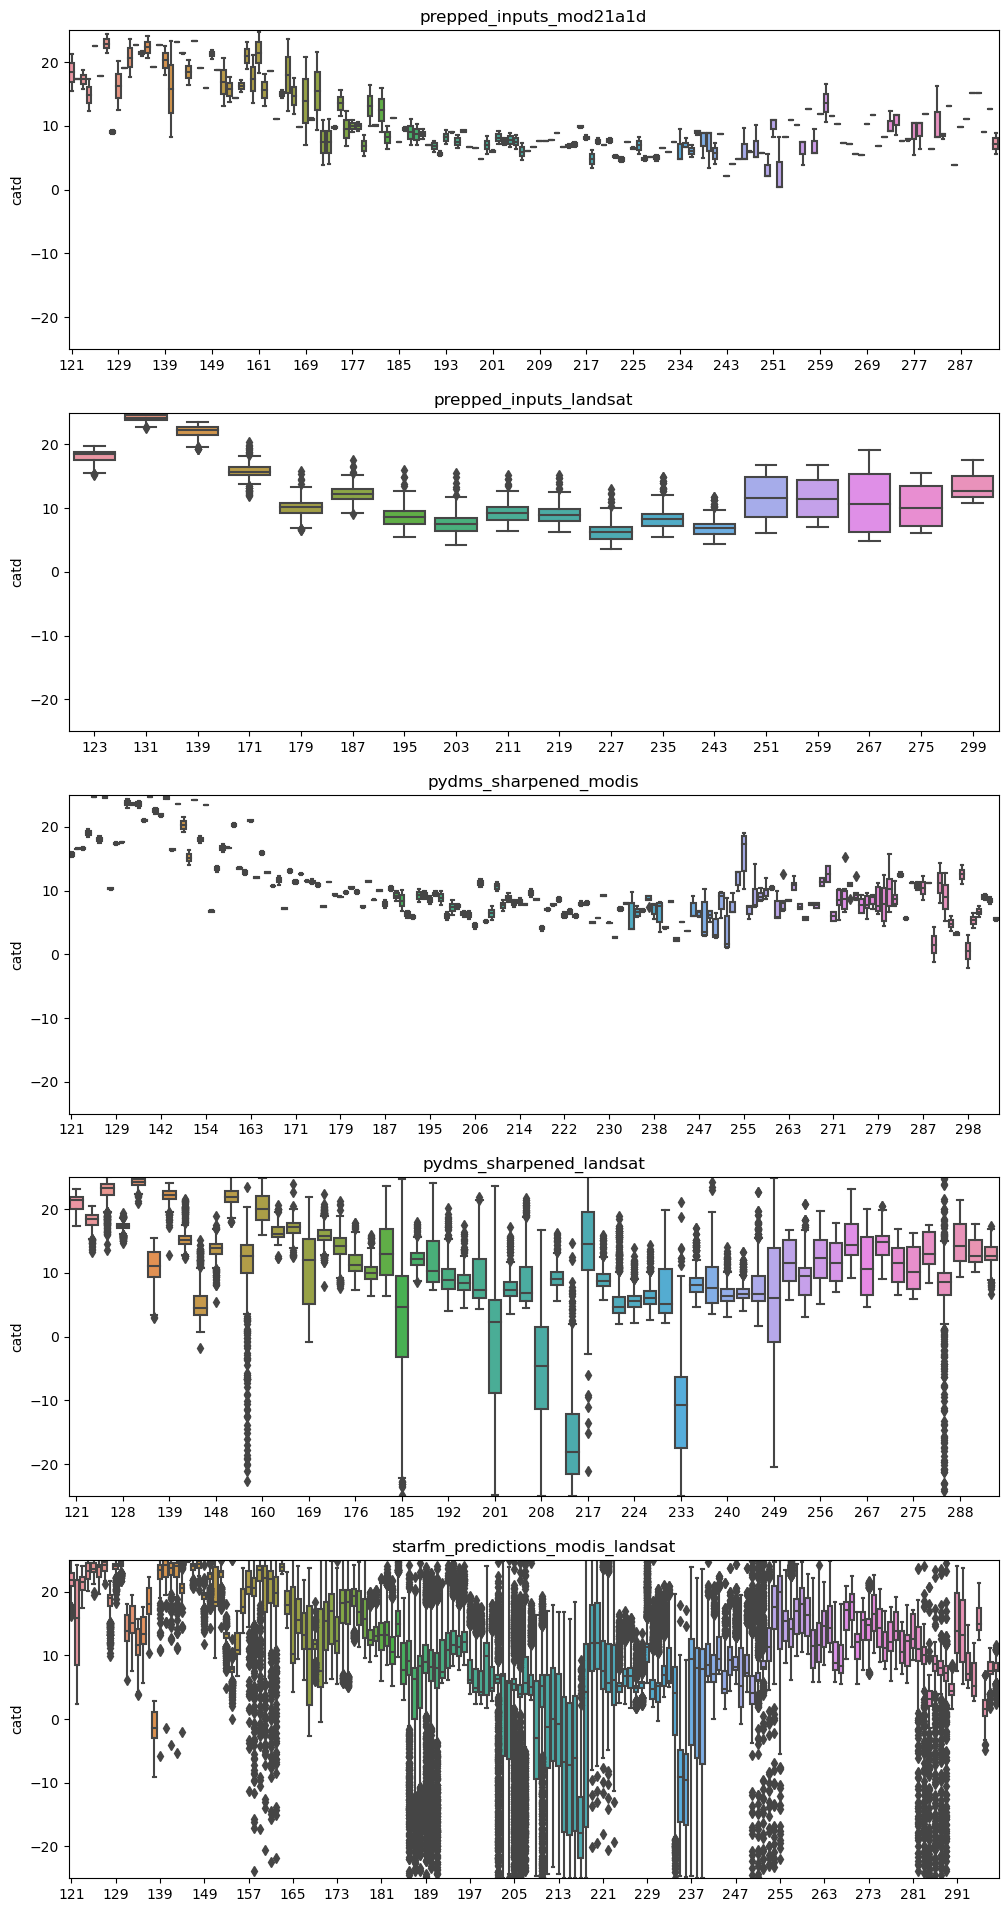

In [24]:
import seaborn as sns
from matplotlib import ticker

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 24))

asset_list = list(asset_dict.keys())

# --------------------------------------------------
i = 0
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

print ('CATD Mean:', df_new['catd'].mean())
print ('CATD SDEV:', df_new['catd'].std())

#df_list[4].catd.plot()
sns.boxplot(x=df_new.index.dayofyear,
                    y=df_new['catd'],
                    ax=ax1).set(title=asset_list[i])

ax1.xaxis.set_major_locator(ticker.MultipleLocator(8))
ax1.set_ylim(-25,25)

# --------------------------------------------------
i = 1
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

print ('CATD Mean:', df_new['catd'].mean())
print ('CATD SDEV:', df_new['catd'].std())

#df_list[4].catd.plot()
sns.boxplot(x=df_new.index.dayofyear,
                    y=df_new['catd'],
                    ax=ax2).set(title=asset_list[i])

#ax2.xaxis.set_major_locator(ticker.MultipleLocator(8))
ax2.set_ylim(-25,25)

# --------------------------------------------------
i = 2
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

print ('CATD Mean:', df_new['catd'].mean())
print ('CATD SDEV:', df_new['catd'].std())

#df_list[4].catd.plot()
sns.boxplot(x=df_new.index.dayofyear,
                    y=df_new['catd'],
                    ax=ax3).set(title=asset_list[i])

ax3.xaxis.set_major_locator(ticker.MultipleLocator(8))
ax3.set_ylim(-25,25)

# --------------------------------------------------
i = 3
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

print ('CATD Mean:', df_new['catd'].mean())
print ('CATD SDEV:', df_new['catd'].std())

#df_list[4].catd.plot()
sns.boxplot(x=df_new.index.dayofyear,
                    y=df_new['catd'],
                    ax=ax4).set(title=asset_list[i])

ax4.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax4.set_ylim(-25,25)

# --------------------------------------------------
i = 4
df = df_list[i]
df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

print ('CATD Mean:', df_new['catd'].abs().mean())
print ('CATD SDEV:', df_new['catd'].std())

#df_list[4].catd.plot()
sns.boxplot(x=df_new.index.dayofyear,
                    y=df_new['catd'],
                    ax=ax5).set(title=asset_list[i])

ax5.xaxis.set_major_locator(ticker.MultipleLocator(8))
ax5.set_ylim(-25,25)

### Scatterplots of CATD vs NDVI for each Collection.

Text(0, 0.5, 'NDVI')

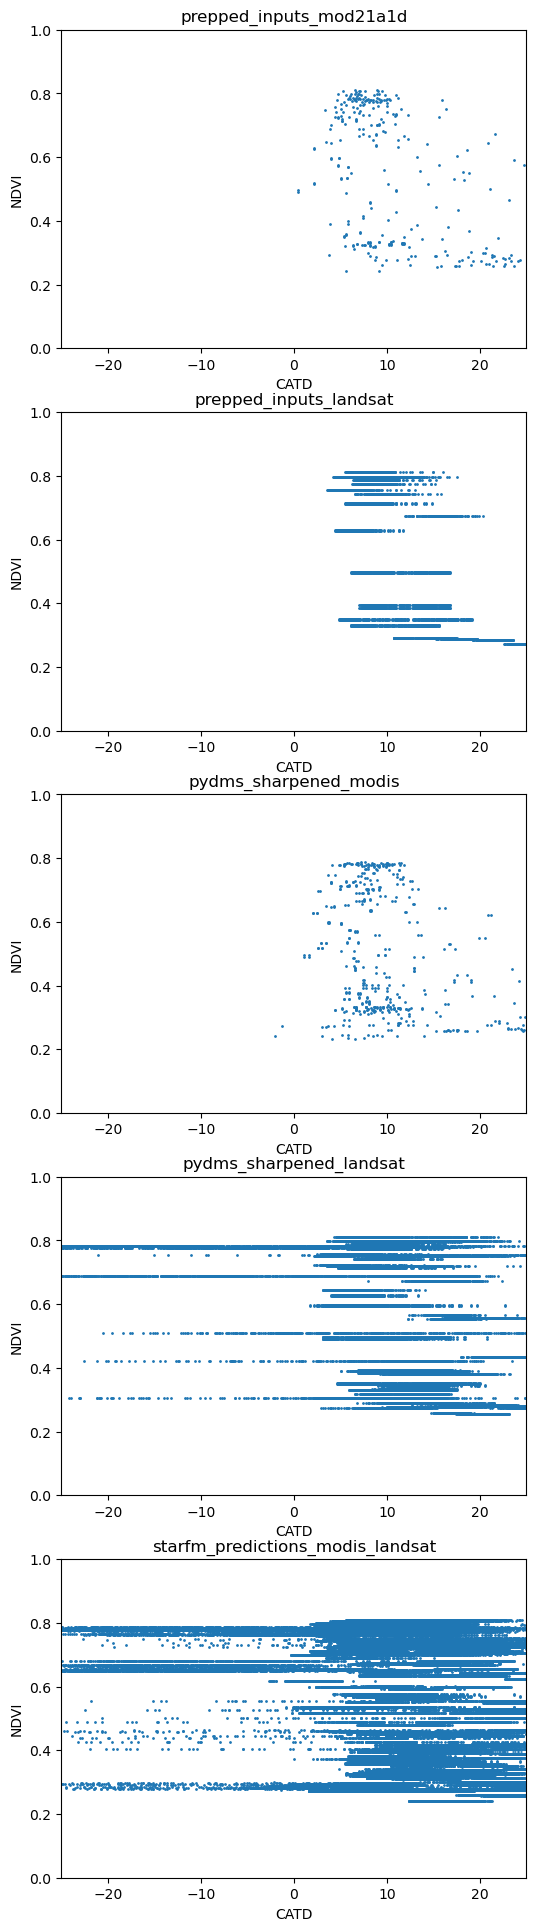

In [28]:
import seaborn as sns
from matplotlib import ticker

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(6, 24))

asset_list = list(asset_dict.keys())

# --------------------------------------------------
i = 0
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

ax1.scatter(df_new['catd'], df_new['prepped_inputs_mcd43a4_corn_ndvi'], s=1)
ax1.set_xlim(-25,25)
ax1.set_ylim(0,1)
ax1.set_title(label=asset_list[i])
ax1.set_xlabel('CATD')
ax1.set_ylabel('NDVI')

# --------------------------------------------------
i = 1
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

ax2.scatter(df_new['catd'], df_new['prepped_inputs_mcd43a4_corn_ndvi'], s=1)
ax2.set_xlim(-25,25)
ax2.set_ylim(0,1)
ax2.set_title(label=asset_list[i])
ax2.set_xlabel('CATD')
ax2.set_ylabel('NDVI')

# --------------------------------------------------
i = 2
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

ax3.scatter(df_new['catd'], df_new['prepped_inputs_mcd43a4_corn_ndvi'], s=1)
ax3.set_xlim(-25,25)
ax3.set_ylim(0,1)
ax3.set_title(label=asset_list[i])
ax3.set_xlabel('CATD')
ax3.set_ylabel('NDVI')

# --------------------------------------------------
i = 3
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

ax4.scatter(df_new['catd'], df_new['prepped_inputs_mcd43a4_corn_ndvi'], s=1)
ax4.set_xlim(-25,25)
ax4.set_ylim(0,1)
ax4.set_title(label=asset_list[i])
ax4.set_xlabel('CATD')
ax4.set_ylabel('NDVI')

# --------------------------------------------------
i = 4
df = df_list[i]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

ax5.scatter(df_new['catd'], df_new['prepped_inputs_mcd43a4_corn_ndvi'], s=1)
ax5.set_xlim(-25,25)
ax5.set_ylim(0,1)
ax5.set_title(label=asset_list[i])
ax5.set_xlabel('CATD')
ax5.set_ylabel('NDVI')

CATD Mean: 11.64269446122358
CATD SDEV: 4.9363684039500875


[Text(0.5, 1.0, 'catd: starfm_predictions_modis_landsat')]

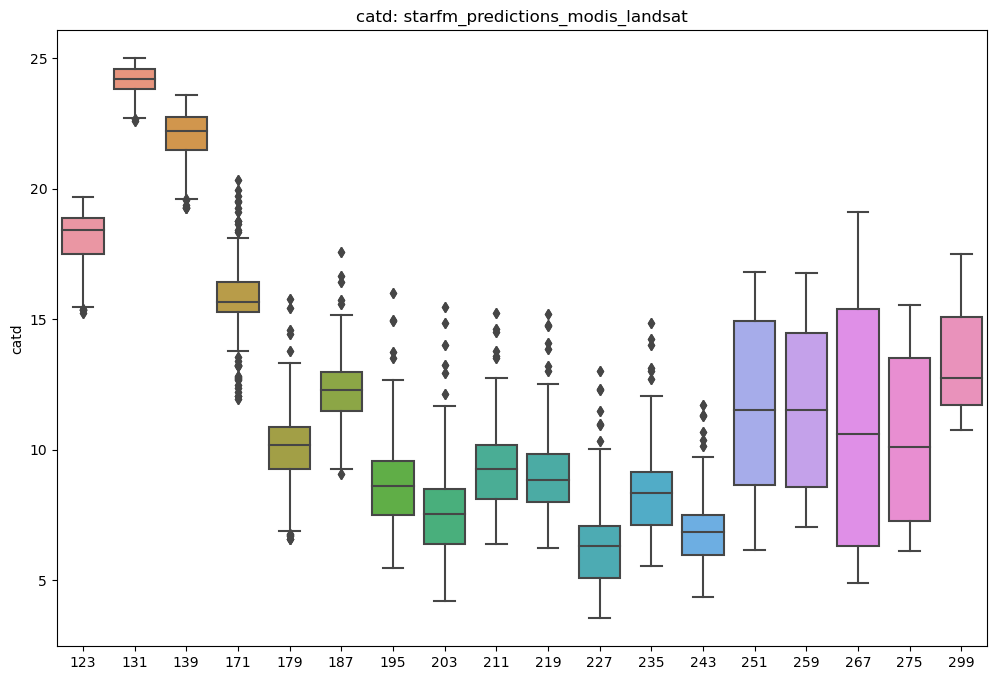

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

df = df_list[1]
df.index = pd.to_datetime(df.index)

df_new = df[(df['catd'] > -25) & (df['catd'] < 25)]
df_new.index = pd.to_datetime(df_new.index)

print ('CATD Mean:', df_new['catd'].mean())
print ('CATD SDEV:', df_new['catd'].std())

#df_list[4].catd.plot()
sns.boxplot(x=df_new.index.dayofyear,
                    y=df_new['catd'],
                    ax=ax).set(title='catd: starfm_predictions_modis_landsat')

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
#ax.set_xticks([30,31,31,30,30,31])

#ax.set_xticklabels(labels = 
#                     df_new.index.strftime(
#                    '%Y-%m-%d').sort_values().unique(), 
#                    rotation=90, ha='right')


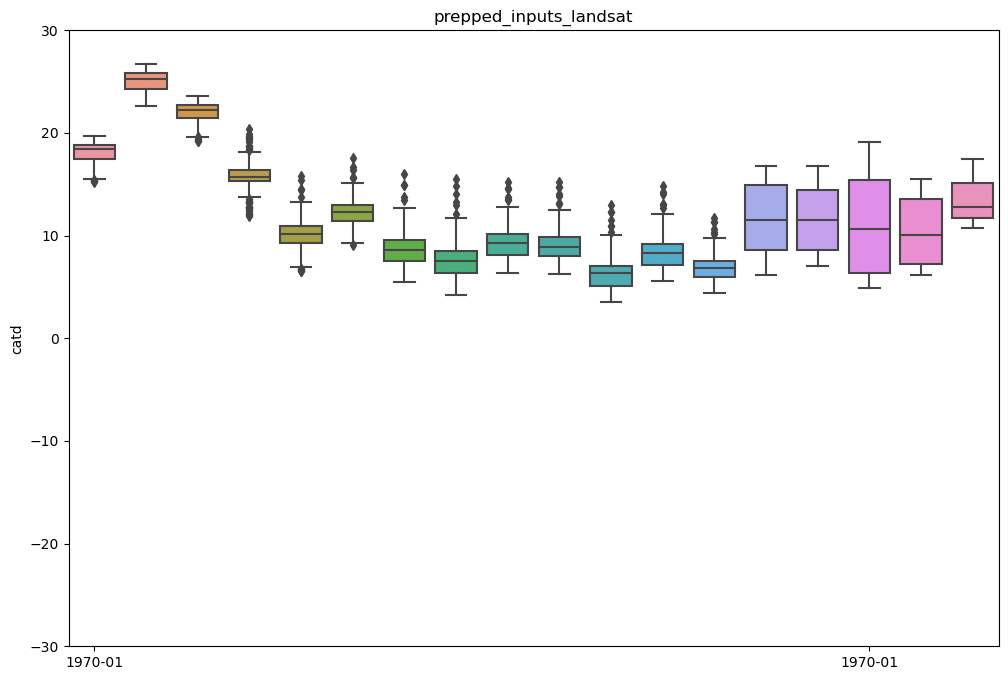

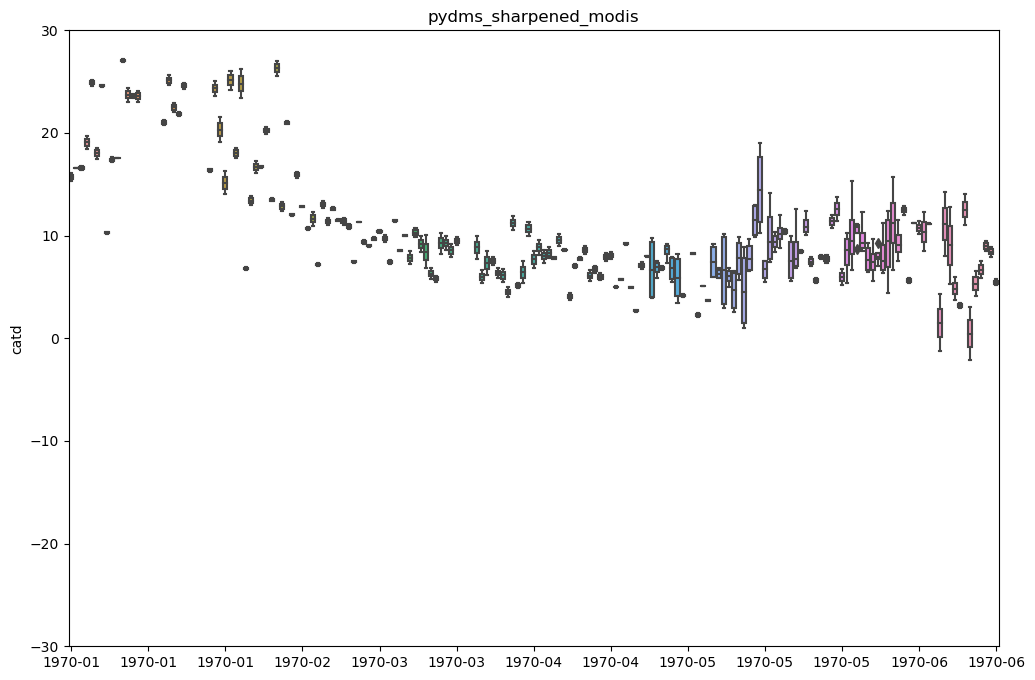

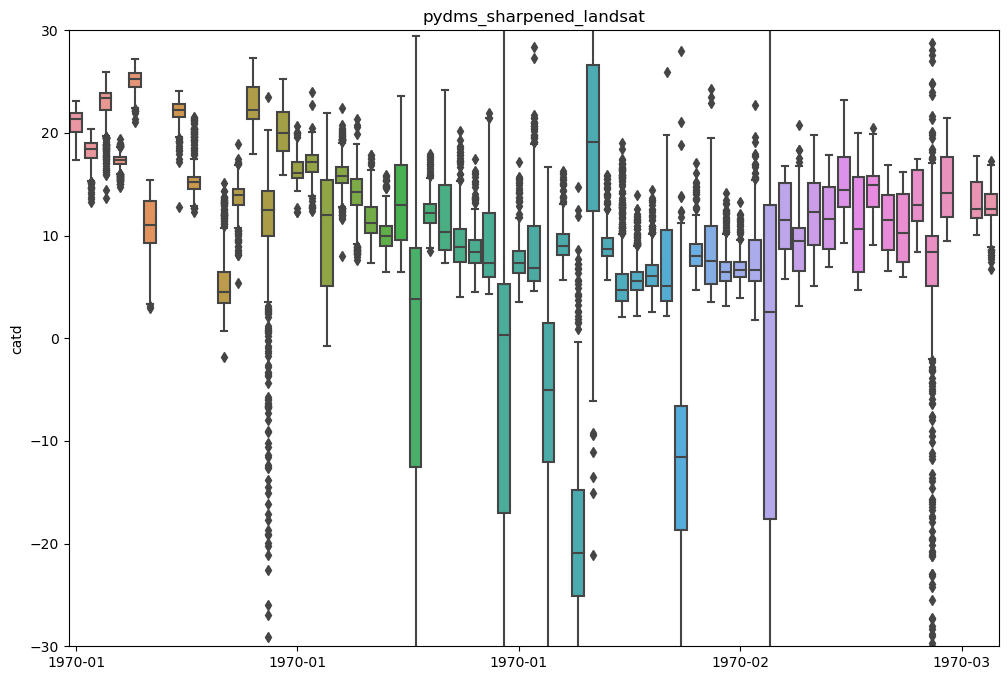

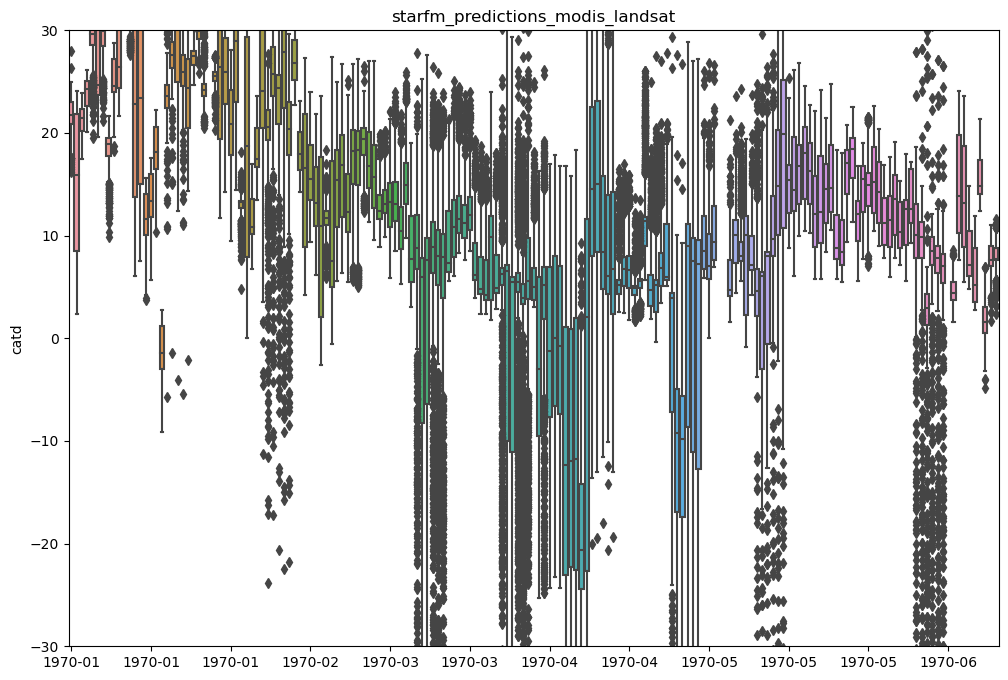

In [88]:
import seaborn as sns

# Define the fig and the number of subplots.

asset_list = list(asset_dict.keys())

j=0
for df in (df_list):

    if j > 0:
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

        df.index = pd.to_datetime(df.index)

        sns.boxplot(x=df.index.dayofyear,
                    y=df['catd'],
                    ax=ax).set(title=asset_list[j])

        plt.ylim(-30, 30)
        
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(15))

        #ax.set_xticklabels(labels = 
        #                   df['2021-05-01':'2021-10-31'].index.strftime(
        #                    '%Y-%m-%d').sort_values().unique(), 
        #                    rotation=45, ha='right')
        
    j = j+1


[Text(0, 0, '2022-05-03'),
 Text(1, 0, '2022-05-11'),
 Text(2, 0, '2022-05-19'),
 Text(3, 0, '2022-06-20'),
 Text(4, 0, '2022-06-28'),
 Text(5, 0, '2022-07-06'),
 Text(6, 0, '2022-07-14'),
 Text(7, 0, '2022-07-22'),
 Text(8, 0, '2022-07-30'),
 Text(9, 0, '2022-08-07'),
 Text(10, 0, '2022-08-15'),
 Text(11, 0, '2022-08-23'),
 Text(12, 0, '2022-08-31'),
 Text(13, 0, '2022-09-08'),
 Text(14, 0, '2022-09-16'),
 Text(15, 0, '2022-09-24'),
 Text(16, 0, '2022-10-02'),
 Text(17, 0, '2022-10-26')]

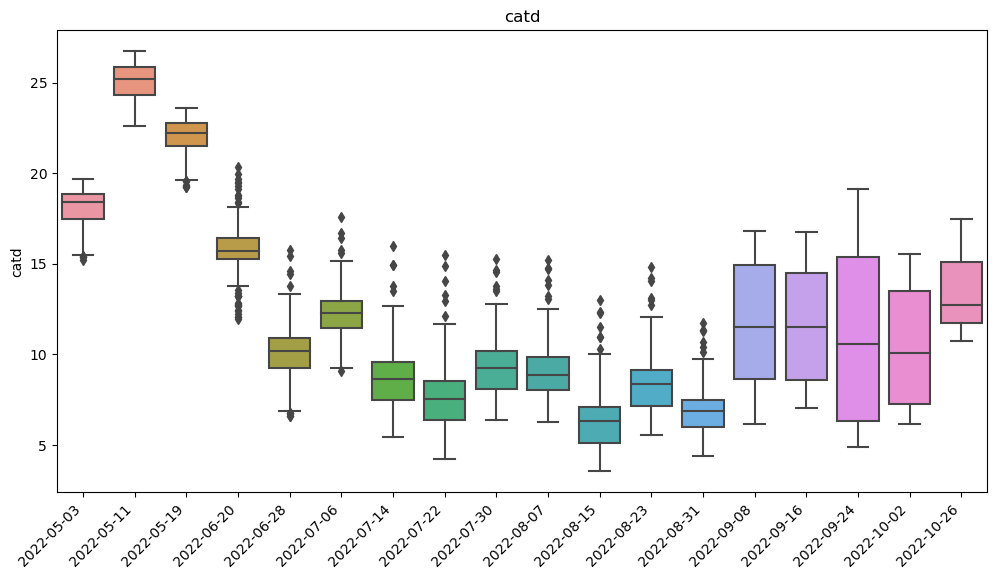

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))

lst_ta_df.index = pd.to_datetime(lst_ta_df.index)

sns.boxplot(x=lst_ta_df.index.dayofyear,
            y=lst_ta_df['catd'],
            ax=ax).set(title='catd')

ax.set_xticklabels(labels = 
    lst_ta_df.index.strftime(
        '%Y-%m-%d').sort_values().unique(), 
    rotation=45, ha='right')

## Plot the results of LST from all collections
Here we plot the LST values extracted from the data collections.

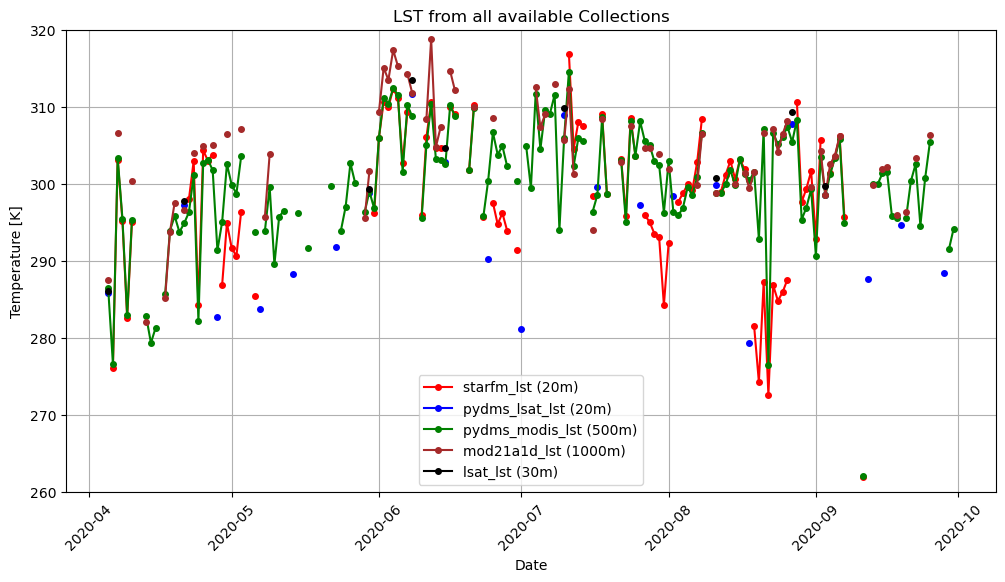

In [ ]:
# Now plot LST and 2mT ----------------------

fig, ax = plt.subplots(figsize=(12, 6))

for i, asset in enumerate(asset_dict):

    ax = (plt.plot(
        master_lst_df.index, master_lst_df[asset_dict[asset][0]], 
        label="{} ({}m)".format(asset_dict[asset][0], asset_dict[asset][2]),
        marker='o', markersize=4, c=asset_dict[asset][3],)
        )

# This may cut off some outlying points.
plt.ylim(260, 320)

plt.title('LST from all available Collections')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Download HRRR 2-m Temperature data
We will compare the LST data for the point with High-Resolution Rapid Refresh (HRRR) data. HRRR is meteorological data provided by NOAA and accessed via the package `herbie`. Data are again stored in a `pandas` DataFrame. Data will be downloaded to the home directory.

In [ ]:
# Get the hrrr data.
hrrr = get_hrrr_point_data(lat, lon, start, num_days)

# Convert to dataframe and clean it up.
# Get a dataset of point hrrr and convert to dataframe for easier use.
hrrr_df = hrrr.to_dataframe()

# Make date consistent in format.
hrrr_df.reset_index(inplace=True)
hrrr_df['date'] = pd.to_datetime(hrrr_df['time'].dt.date)

# Set the index to date just like the other dataframes.
hrrr_df.set_index('date', inplace=True)

c:\Users\Erik_Anderson\miniconda3\envs\ea-lst-alpha\Lib\site-packages\pyproj\transformer.py:812: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(


## Plot HRRR air temperature
Here we plot the HRRR air temperature data.

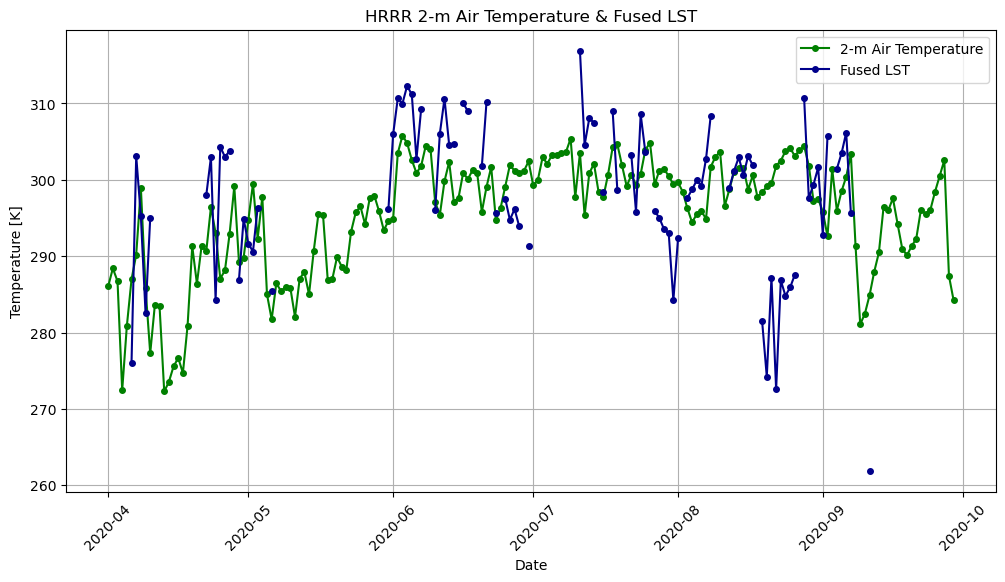

In [ ]:
# Now plot HRRR 2-m Temperature  ----------------------

fig, ax = plt.subplots(figsize=(12, 6))

ax = (plt.plot(
    hrrr_df.index, 
    hrrr_df['t2m'], 
    label="2-m Air Temperature",
    marker='o', markersize=4, c='green',
    ))

ax = (plt.plot(
    master_lst_df.index, 
    master_lst_df['starfm_lst'],
    label="Fused LST",
    marker='o', markersize=4, c='darkblue',
    ))

plt.title('HRRR 2-m Air Temperature & Fused LST')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### A Leading Index Candidate?
### Calculate Canopy Air Temperature Difference (CATD) from Fused LST

CATD = Leaf Surface Temperature - Air Temperature
<br /><br />
or
<br /><br />
CATD = LST - Air Temperature

In [ ]:
# CATD will be calculated as:
#    CATD = asset's LST - HRRR 2m Temperatures

# Create a new dataframe and pre-fill with dates.
days = pd.date_range(start, end) 
catd_df = pd.DataFrame({'date': days})
catd_df.set_index('date', inplace=True)

# Loop through the master_lst_df and calculate CATD for each asset.
# Save in a CATD dataframe.
for i, asset in enumerate(asset_dict):

    catd_col = "catd_{}".format(asset_dict[asset][0])
    catd_df[catd_col] = master_lst_df[asset_dict[asset][0]].sub(hrrr_df['t2m'])


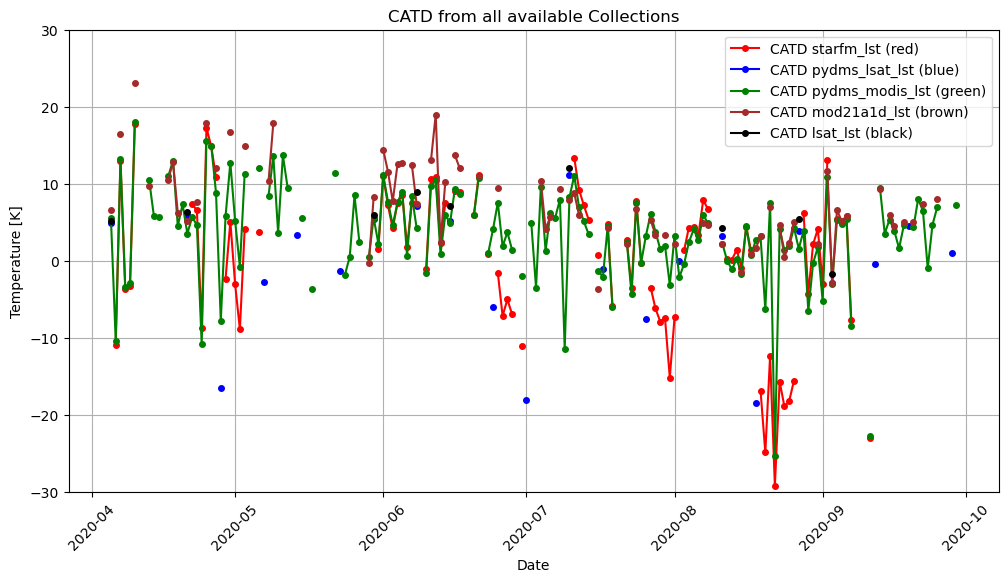

In [ ]:
# Now plot CATD  ----------------------

fig, ax = plt.subplots(figsize=(12, 6))

for i, asset in enumerate(asset_dict):

    # This the the name of the columns in the catd df.
    # Just makes it shorter for later use.
    col = "catd_{}".format(asset_dict[asset][0])

    ax = (plt.plot(
        catd_df.index, 
        catd_df[col], 
        label="CATD {} ({})".format(asset_dict[asset][0], asset_dict[asset][3]),
        marker='o', markersize=4, c=asset_dict[asset][3]),
        )

# This may cut off some outlying points.
plt.ylim(-30, 30)

plt.title('CATD from all available Collections')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Plot CATD from Fused LST only
This plot highlights the results of the CATD for the fused LST only.

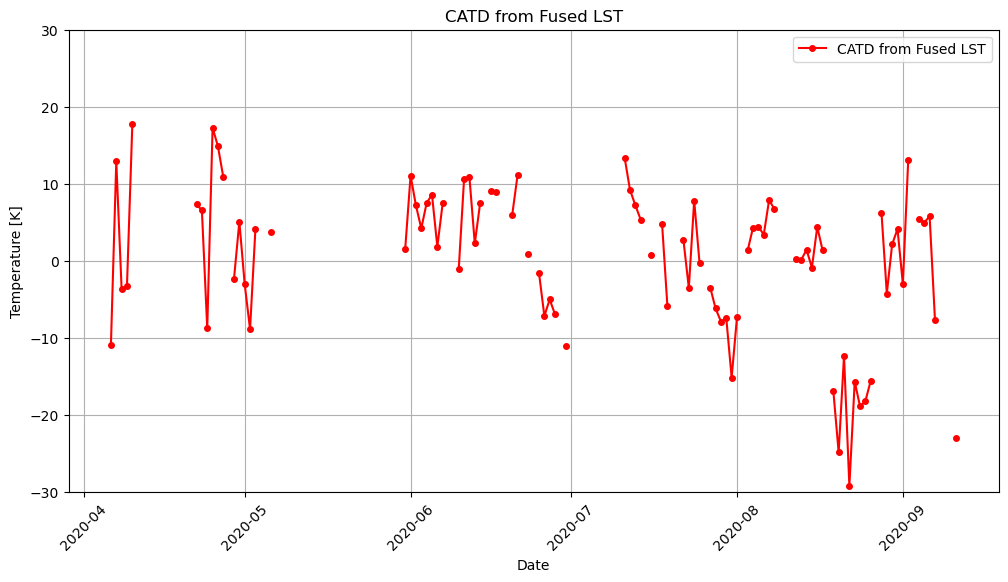

In [ ]:
# Plotting fused CATD alone.

fig, ax = plt.subplots(figsize=(12, 6))

ax = (plt.plot(
    catd_df.index, 
    catd_df['catd_starfm_lst'], 
    label="CATD from Fused LST",
    marker='o', markersize=4, c='red',
    ))

# This may cut off some outlying points.
plt.ylim(-30, 30)

plt.title('CATD from Fused LST')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Calculate NDVI - The "greenness" or health of leaves. 
Surface reflectance is extracted for each collection and NDVI is calculated.

In [ ]:
# NDVI collections to search.
# Dictionary keys are: var_name, tolerance, band nir, band red, resolution, plot color.
asset_dict = {
    "prepped_inputs_mcd43a4" : ['mcd43a4_band', 1000, 'b1', 'b0', '500m', 'blue'],
    "prepped_inputs_s2" : ['sentinel2_band', 40, 'b6', 'b2', '20m', 'red'],
    "starfm_predictions_modis_s2" : ['starfm_band', 40, 'b0', 'b0', '20m', 'green'],
}

# Create new master dataframe to append to
# starting with our full date range.
days = pd.date_range(start, end) 
master_ndvi_df = pd.DataFrame({'date': days})
master_ndvi_df.set_index('date', inplace=True)

for i, collection in enumerate(asset_dict):

    # Search and retrieve images.
    (found_items, num_tiles) = stac_tile_search(collection, geom, start_date, end_date)

    # The starfm collection is queried differently than the other collections
    # so we need an if condition to treat the requests differently.
    if collection == ('starfm_predictions_modis_s2'):

        # Extract red
        asset = 'surface_reflectance_red'
        (red_time_series_df) = (extract_time_series(
            found_items, bbox, 
            asset_dict[collection][1], 'red_sr', 
            asset, band=0 ))
        
        # Extract nir
        asset = 'surface_reflectance_nir'
        (nir_time_series_df) = (extract_time_series(
            found_items, bbox, 
            asset_dict[collection][1], 'nir_sr', 
            asset, band=0 ))
        
        # Copute NDVI
        ndvi_df = pd.DataFrame()
        ndvi = ((nir_time_series_df['nir_sr'] - red_time_series_df['red_sr']) 
                / (nir_time_series_df['nir_sr'] + red_time_series_df['red_sr']))
        
         # Give the ndvi data column an appropriate name.
        var_name = "ndvi_{}".format(asset_dict[collection][0])
        ndvi_df[var_name] = ndvi
       
    else:

        # Extract red band ----------
        asset = 'surface_reflectance'
        red_band = (asset_dict[collection][3])[-1]
        (red_time_series_df) = (extract_time_series(
            found_items, bbox, 
            asset_dict[collection][1], 'red_sr', 
            asset, band=red_band))
        
        # Extract nir band ----------
        asset = 'surface_reflectance'
        nir_band = (asset_dict[collection][2])[-1]
        (nir_time_series_df) = (extract_time_series(
            found_items, bbox, 
            asset_dict[collection][1], 'nir_sr', 
            asset, band=nir_band ))

        # Copute NDVI
        ndvi_df = pd.DataFrame()
        ndvi = ((nir_time_series_df['nir_sr'] - red_time_series_df['red_sr']) 
                / (nir_time_series_df['nir_sr'] + red_time_series_df['red_sr']))
       
        # Give the ndvi data column an appropriate name.
        var_name = "ndvi_{}".format(asset_dict[collection][0])
        ndvi_df[var_name] = ndvi


    # Merge each df into master dataframe.
    # Merge on index (date) and keep all rows from both dfs (inner join).
    master_ndvi_df = pd.merge(
        master_ndvi_df, ndvi_df, 
        left_index=True, right_index=True, how = 'outer')  

colllection: prepped_inputs_mcd43a4 

Number of fusion tiles available: 175
using 6 processes to sample 175 assets
using 6 processes to sample 175 assets
colllection: prepped_inputs_s2 

Number of fusion tiles available: 40
using 6 processes to sample 40 assets
using 6 processes to sample 40 assets
colllection: starfm_predictions_modis_s2 

Number of fusion tiles available: 144
using 6 processes to sample 144 assets
using 6 processes to sample 144 assets


## Plot NDVI
Here we plot NDVI for each asset.

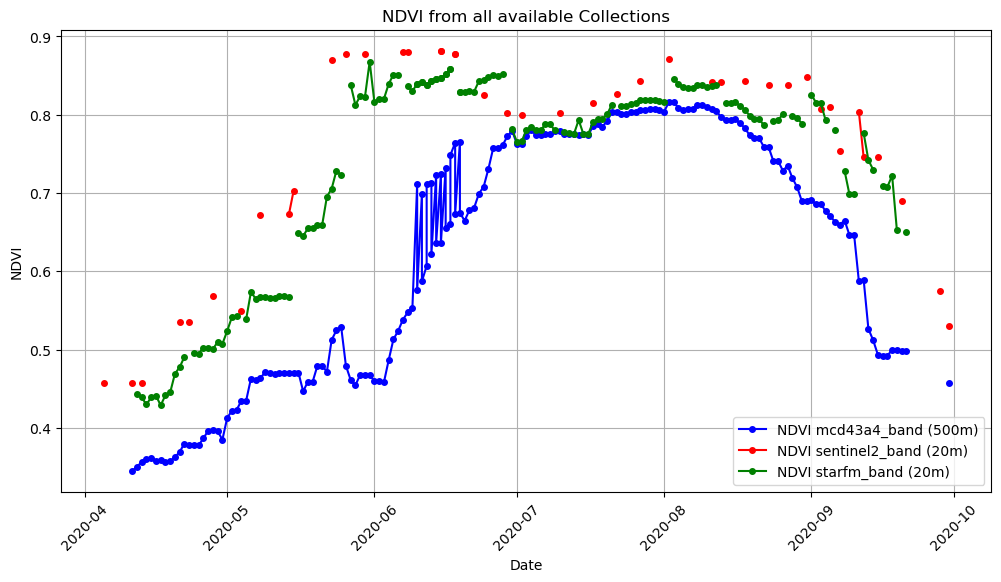

In [ ]:
# Now plot NDVI ----------------------
asset_dict = {
    "prepped_inputs_mcd43a4" : ['mcd43a4_band', 1000, 'b1', 'b0', '500m', 'blue'],
    "prepped_inputs_s2" : ['sentinel2_band', 40, 'b6', 'b2', '20m', 'red'],
    "starfm_predictions_modis_s2" : ['starfm_band', 40, 'b0', 'b0', '20m', 'green'],
}

fig, ax = plt.subplots(figsize=(12, 6))

for i, collection in enumerate(asset_dict):

    var_name = "ndvi_{}".format(asset_dict[collection][0])

    ax = (plt.plot(
        master_ndvi_df.index, 
        master_ndvi_df[var_name], 
        label="NDVI {} ({})".format(asset_dict[collection][0], asset_dict[collection][4]),
        marker='o', markersize=4, c=asset_dict[collection][5]),
        )

plt.title('NDVI from all available Collections')
plt.grid(True)
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Is CATD a Leading Index Candidate?
### Plot Canopy Air Temperature Difference (CATD) vs. NDVI

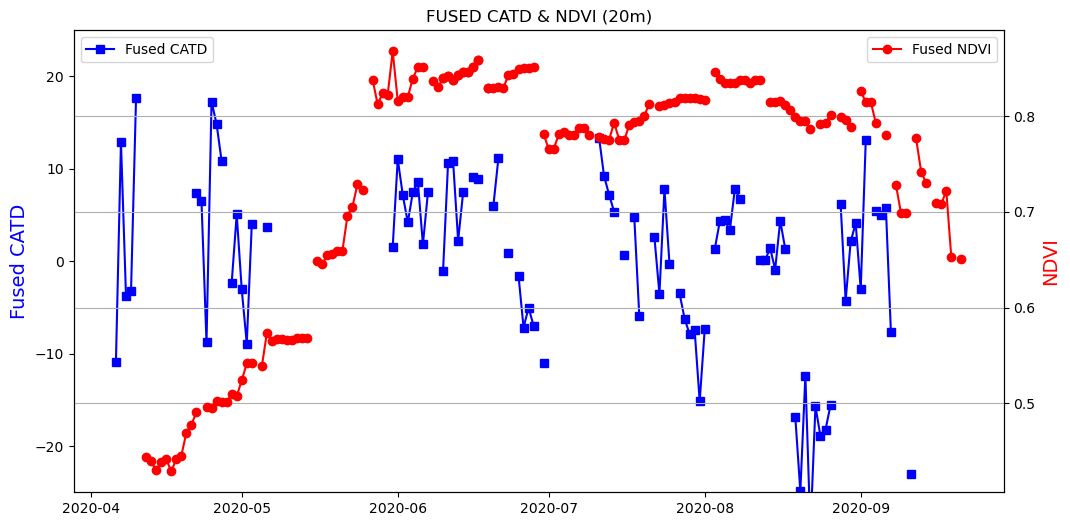

In [ ]:
# Plotting fused CATD alone.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

(ax1.plot(catd_df.index, catd_df['catd_starfm_lst'], 
    label='Fused CATD', marker='s', c='b'))

(ax2.plot(master_ndvi_df.index, master_ndvi_df['ndvi_starfm_band'], 
    label='Fused NDVI', marker='o', c='r',))

ax1.set_ylim(-25, 25)

ax1.set_ylabel("Fused CATD", color='blue', fontsize=14)
ax2.set_ylabel("Fused NDVI", color='red', fontsize=14)

plt.title('FUSED CATD & NDVI (20m)')
plt.grid(True)
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.xticks(rotation=45)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

### Plot 7-Day rolling mean to smooth out the data.

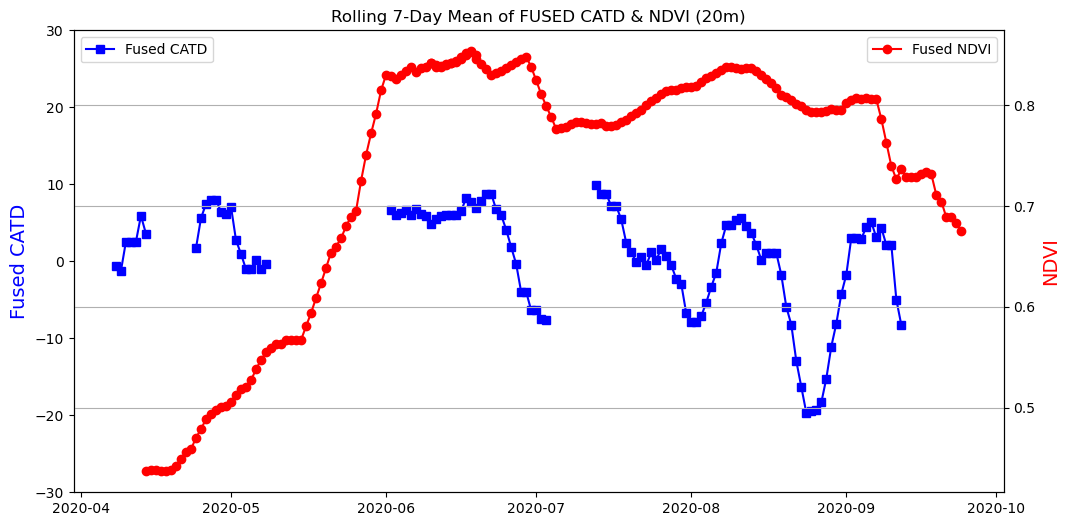

In [ ]:
# Plotting fused CATD alone.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

(ax1.plot(catd_df.index, catd_df['catd_starfm_lst']
          .rolling(7, min_periods=3).mean(), 
          label='Fused CATD', marker='s', c='b'))

(ax2.plot(master_ndvi_df.index, master_ndvi_df['ndvi_starfm_band']
          .rolling(7, min_periods=3).mean(), 
          label='Fused NDVI', marker='o', c='r',))

ax1.set_ylim(-30,30)

ax1.set_ylabel("Fused CATD", color='blue', fontsize=14)
ax2.set_ylabel("Fused NDVI", color='red', fontsize=14)

plt.title('Rolling 7-Day Mean of FUSED CATD & NDVI (20m)')
plt.grid(True)
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.xticks(rotation=45)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

## <span style="color:green"> Take-aways from initial data exploration</span>

- <font size="5">We dont know how the field was managed.</font>

- <font size="5">The LST variance between the fused components is significant.</font>

- <font size="5">There is significant missing data (clouds or bad raw image).</font>

- <font size="5">CATD swings quite wildly from day to day - the LST doesnt help.</font>

- <font size="5">There are windows when an decreasing CATD seems to precede a decrease in NDVI, but not always.  It brings up a number of questions:</font>

    1. <font size="5" color="lightblue">Is there an optimal CATD zone for vegetation growth?</font>

    2. <font size="5" color="lightblue">Does a multi day increasing (slope) CATD lead to NDVI stagnation or decline?</font>

    3. <font size="5" color="lightblue">When CATD is near zero, is that the start of stress because presumably stomata are closed and evapotranspiration has ceased cooling the leaves?</font>
